In [8]:
import pytransit
import corner
import arviz as az
import matplotlib.pyplot as plt
import exoplanet as xo
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx

In [9]:
def rootdir(*args):
    return os.path.join("..", *args)

def datadir(*args):
    return rootdir("data", *args)

In [45]:
ground_truth = {
    "period": 3.5,
    "t0": 1.3,
    "us": [0.5, 0.2],
    "r": 0.03,
    "a": 10.0,
    "yerr": 1e-4
}

In [11]:
with np.load(datadir("generated_data_100ppm.npz")) as data:
    t = data["t"]
    flux = data["flux"]

In [84]:
import theano.tensor as tt
from theano.compile.ops import as_op

tm = pytransit.QuadraticModel()
tm.set_data(t)

def PyTransitlightcurve_np(t0, period, a, r, us):
       return tm.evaluate(r, us, t0, period, a, np.pi/2)

@as_op(itypes = [tt.dscalar, tt.dscalar, tt.dscalar, tt.dscalar, tt.dvector],
       otypes = [tt.dvector])
def PyTransitlightcurve(*inputs):
       np_ins = [np.atleast_1d(inp) for inp in inputs]
       return PyTransitlightcurve_np(*np_ins)

In [103]:
from ops import PyTransitlightcurve

with pm.Model() as model:
    # evaluate period in log-space
    logP = pm.Normal("logP", mu=np.log(ground_truth["period"]), sd=0.1)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # wide prior on t0 to try and help latch onto truth
    t0 = pm.Normal("t0", sd=10, testval=ground_truth["t0"])

    # Kipping (2013) parameterization
    us = xo.distributions.QuadLimbDark("us", testval=ground_truth["us"])

    r = pm.Uniform("r", lower=0.01, upper=0.1, testval=ground_truth["r"])

    # evaluate a in log-space
    loga = pm.Normal("loga", mu=np.log(ground_truth["a"]), sd=0.1)
    a = pm.Deterministic("a", pm.math.exp(loga))
   
    y = pm.Deterministic("y", PyTransitlightcurve(t0, period, a, r, us))

    # for error model use basic half-cauchy
    yerr = pm.HalfCauchy("yerr", 0.1, testval=ground_truth["yerr"])

    # Guassian likelihood
    pm.Normal("obs", mu=y, sd=yerr, observed=flux)

In [104]:
with model:
    map_soln = pm.find_MAP(start=model.test_point)

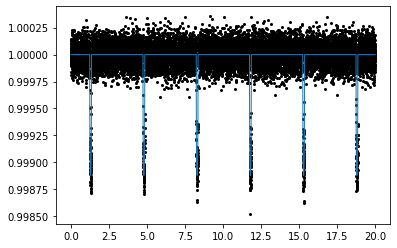

In [105]:
import matplotlib.pyplot as plt
plt.plot(t, flux, ".k", ms=4, label="data")
plt.plot(t, map_soln["y"], lw=1)

In [106]:
np.random.seed(8462852)
with model:
    trace = pm.sample(
        tune=5000,
        draws=10000,
        start=map_soln,
        step=pm.Metropolis(),
        cores=4,
        chains=4,
        return_inferencedata=True
    )

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [yerr]
INFO:pymc3:>Metropolis: [yerr]
>Metropolis: [loga]
INFO:pymc3:>Metropolis: [loga]
>Metropolis: [r]
INFO:pymc3:>Metropolis: [r]
>Metropolis: [us]
INFO:pymc3:>Metropolis: [us]
>Metropolis: [t0]
INFO:pymc3:>Metropolis: [t0]
>Metropolis: [logP]
INFO:pymc3:>Metropolis: [logP]


In [89]:
var_names = ["period", "t0", "r", "a", "us", "yerr"]
with model:
    summary = az.summary(trace, var_names=var_names)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period,3.500,0.000,3.500,3.500,0.000,0.000,11.0,32.0,2.05
t0,1.300,0.000,1.300,1.300,0.000,0.000,14.0,27.0,1.98
r,0.030,0.000,0.030,0.030,0.000,0.000,21.0,46.0,1.15
a,10.030,0.032,9.962,10.075,0.008,0.006,16.0,20.0,1.19
us[0],0.554,0.060,0.449,0.673,0.006,0.004,109.0,838.0,1.04
us[1],0.037,0.108,-0.165,0.241,0.017,0.012,43.0,213.0,1.08
yerr,0.000,0.000,0.000,0.000,0.000,0.000,319.0,376.0,1.01


In [90]:
trace.to_netcdf(datadir("pytransit+MH_trace.nc"))
# make sure loads
# trace = az.InferenceData.from_netcdf(datadir("pytransit+MH_trace.nc"))

'../data/pytransit+MH_trace.nc'

/Users/miles/dev/yeehaw/.venv/lib/python3.7/site-packages/arviz/stats/density_utils.py:248: RuntimeWarning: divide by zero encountered in double_scalars
  t_j = np.power((c1 * (c2 / (N * f))), (2.0 / (3.0 + 2.0 * j)))
/Users/miles/dev/yeehaw/.venv/lib/python3.7/site-packages/arviz/stats/density_utils.py:252: RuntimeWarning: divide by zero encountered in double_scalars
  out = t - (2 * N * np.pi ** 0.5 * f) ** (-0.4)
/Users/miles/dev/yeehaw/.venv/lib/python3.7/site-packages/arviz/stats/density_utils.py:276: RuntimeWarning: invalid value encountered in double_scalars
  bw = (_bw_silverman(x) / np.ptp(x)) ** 2
/Users/miles/dev/yeehaw/.venv/lib/python3.7/site-packages/arviz/stats/density_utils.py:760: RuntimeWarning: invalid value encountered in true_divide
  f = grid_counts / bin_width / len(x)
/Users/miles/dev/yeehaw/.venv/lib/python3.7/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Some

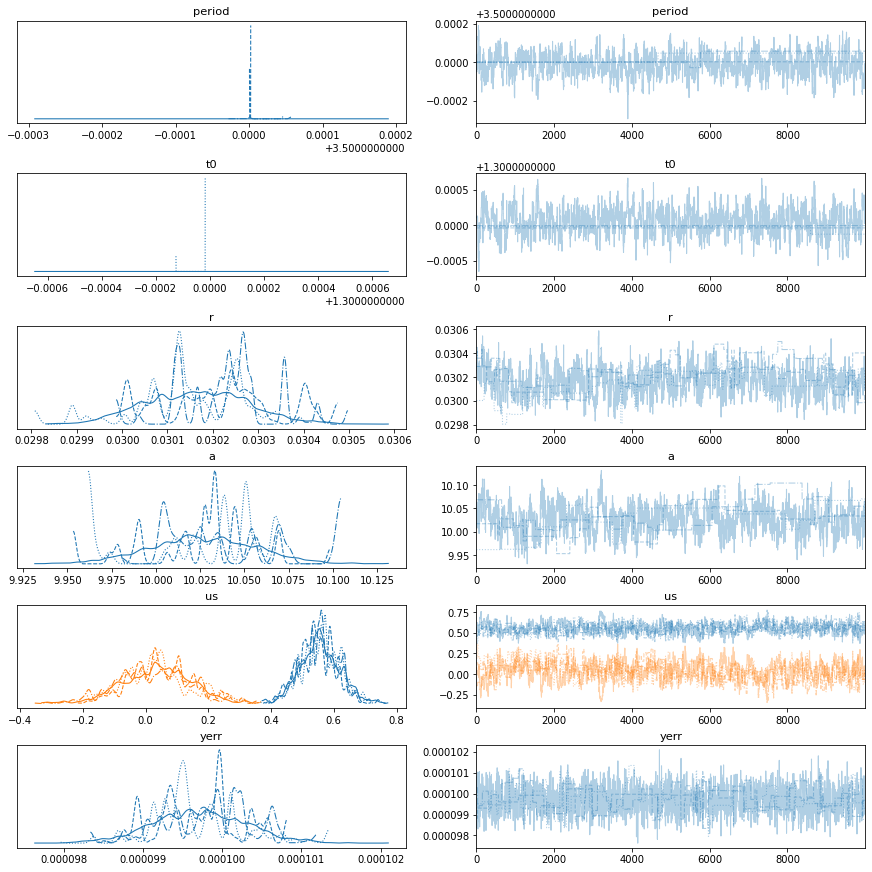

In [91]:
with model:
    az.plot_trace(trace, var_names=var_names);

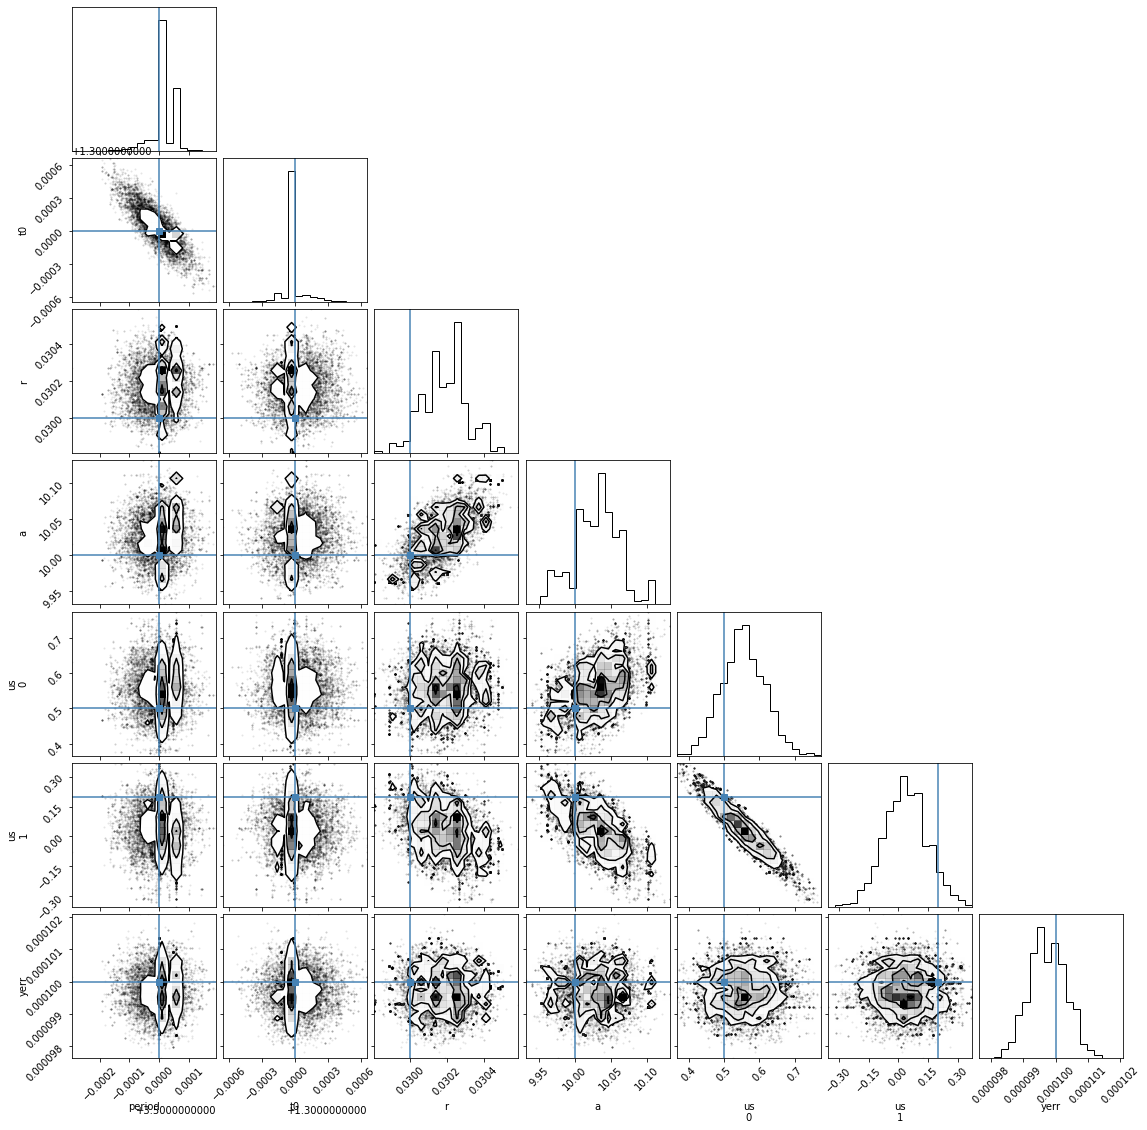

In [92]:
_ = corner.corner(
    trace,
    var_names=var_names,
    truths=ground_truth,
)

In [93]:
# Get the posterior median orbital parameters
p = np.median(trace["posterior"]["period"])
Pmean = np.mean(trace["posterior"]["period"]).values
Pstd = np.std(trace["posterior"]["period"]).values
t0 = np.median(trace["posterior"]["t0"])
pred = trace["posterior"]["y"]
pred = np.median(pred, axis=(0, 1))

In [95]:
with np.load(datadir("generated_data.npz")) as data:
    true_mod = data["flux"]

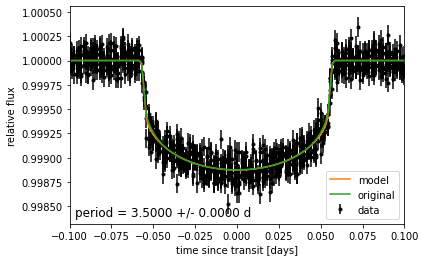

In [96]:
# Plot the folded data
x_fold = (t - ground_truth["t0"] + 0.5 * ground_truth["period"]) % ground_truth["period"] - 0.5 * ground_truth["period"]
plt.errorbar(
    x_fold, flux, yerr=ground_truth["yerr"], fmt=".k", label="data", zorder=-1000
)

# Plot the folded model
maxphase = 0.1
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < maxphase]
plt.plot(x_fold[inds], pred[inds], color="C1", label="model")
plt.plot(x_fold[inds], true_mod[inds], color="C2", label="original")

# Annotate the plot with the planet's period
txt = f"period = {Pmean:.4f} +/- {Pstd:.4f} d"
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10, loc=4)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux")
plt.xlim(-maxphase, maxphase);

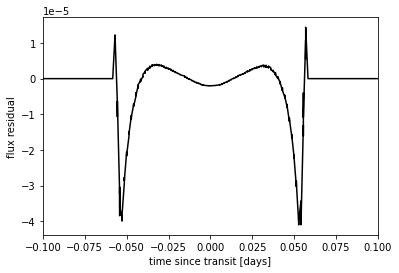

In [99]:
# Plot the folded model residuals
plt.plot(x_fold[inds], pred[inds] - true_mod[inds], color="k")
plt.xlabel("time since transit [days]")
plt.ylabel("flux residual")
plt.xlim(-maxphase, maxphase);